**TIME SERIES ANALYSIS FOR STOCK MARKET DATA SPECIFICALLY AMAZON** 





In [1]:
pip install mxnet

     |████████████████████████████████| 47.3 MB 105 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


**install mxnet a python package for time series data great for visualization**

In [3]:
import time
import numpy as np
import pandas as pd
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [4]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

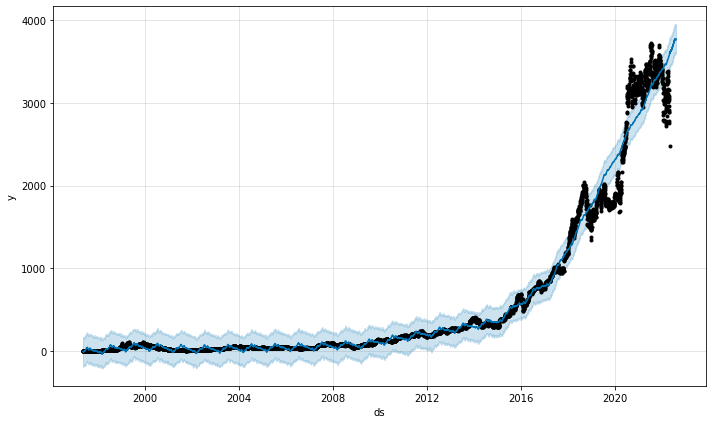

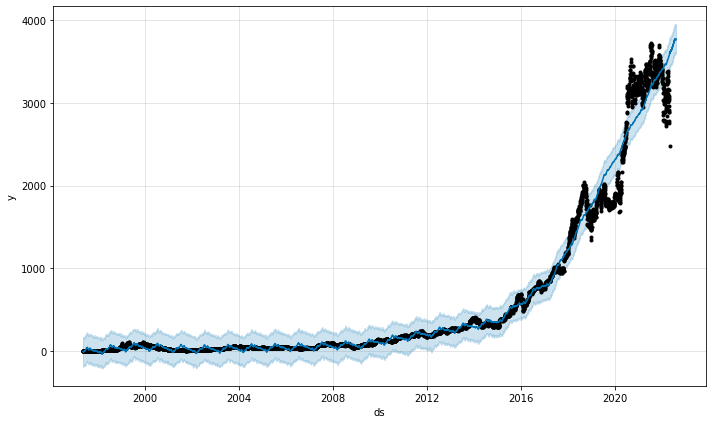

In [5]:
import yfinance as yf
from fbprophet import Prophet
   
    # forecast the given ticker (stock) period days into the future (from today)

    # inputs
    # ------
    # > ticker
    #     >> ticker of stock to forecast
    # > periods
    #     >> number of days into the future to forecast (from today's date)
    # > hist
    #     >> amount of historical data to consider
    #         > default: max
    #         > options: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
   
    # pull historical data from yahoo finance
stock_data = yf.Ticker("AMZN")

hist_data = stock_data.history("max", auto_adjust=True)

    # create new dataframe to hold dates (ds) & adjusted closing prices (y)
df = pd.DataFrame()

df['ds'] = hist_data.index.values
df['y'] = hist_data['Close'].values

    # create a Prophet model from that data
m = Prophet(daily_seasonality=False)
m.fit(df)

future = m.make_future_dataframe(100, freq='D')
forecast = m.predict(future)

m.plot(forecast)

    

In [6]:
df.head()

,ds,y
0,1997-05-15,1.958333
1,1997-05-16,1.729167
2,1997-05-19,1.708333
3,1997-05-20,1.635417
4,1997-05-21,1.427083


In [7]:
def parser(x):
    return datetime.datetime.strptime(x,'%m/%d/%Y')

**Always sort time and format it properily for time series data. Here sorted out it month-date-year format.** 

In [8]:
hist_data.reset_index(inplace=True)
hist_data.head(3)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,72156000,0,0.0
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,14700000,0,0.0
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,6106800,0,0.0


In [9]:
print('There are {} number of days in the dataset.'.format(df.shape[0]))

There are 6282 number of days in the dataset.


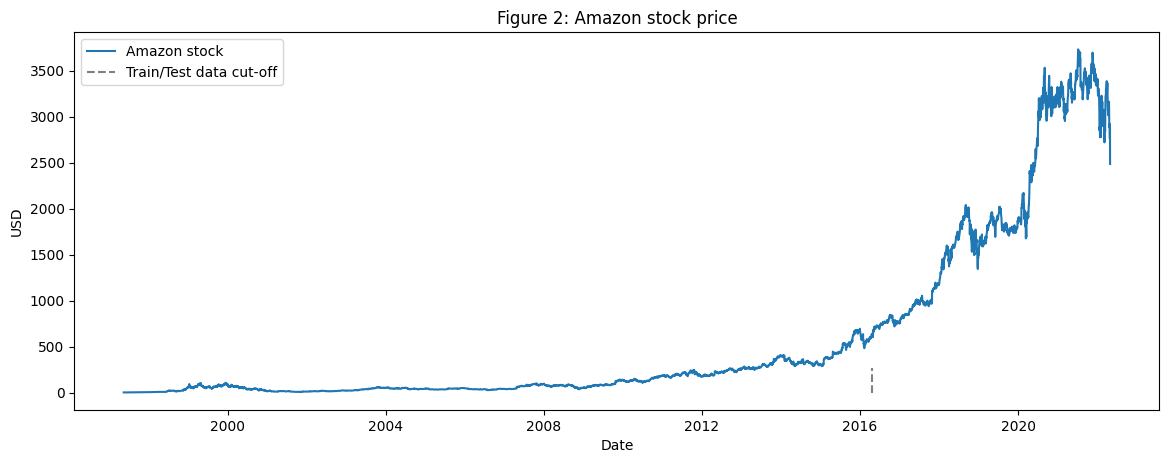

In [10]:
import datetime

plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['ds'], df['y'], label='Amazon stock')
plt.vlines(datetime.date(2016,4,20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Amazon stock price')
plt.legend()
plt.show()


**I have divided the stock data after 2010 upto 2019 for Amazon. 
Amazon business really boomed after 2010 and then peaked after 2015 so the testing will be very interesting since most of the data is in the exponential growth period. What I am going to do it normalize the training data such that similar data points over time are reduced to one single data point so that the model can train in such a way it can expect the exponential growth after 2015.**

**Inorder to predict better i NEED TO GENERATOR FEATURES SO I HAVE MORE INDICATORS TO PREDICT THE DATA**

# **FEATURE GENERATION**

In [11]:
def get_technical_indicators(dataset): #function to generate feature technical indicators
    
    
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()
    
    #Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
    
    #Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)
    
    
    #Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    dataset['momentum'] = (dataset['Close']/100)-1
    
    
    
    return dataset

In [12]:
dataset_TI_df = get_technical_indicators(hist_data)

In [13]:
dataset_TI_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,72156000,0,0.0,NaN,NaN,1.958333,1.958333,0.000000,NaN,NaN,NaN,1.958333,-0.980417
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,14700000,0,0.0,NaN,NaN,1.839343,1.834201,-0.005142,NaN,NaN,NaN,1.786458,-0.982708
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,6106800,0,0.0,NaN,NaN,1.792272,1.785075,-0.007197,NaN,NaN,NaN,1.732372,-0.982917
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,5467200,0,0.0,NaN,NaN,1.748422,1.737834,-0.010589,NaN,NaN,NaN,1.666927,-0.983646
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,18853200,0,0.0,NaN,NaN,1.673903,1.653404,-0.020499,NaN,NaN,NaN,1.506370,-0.985729


In [14]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Amazon - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

   

    plt.show()

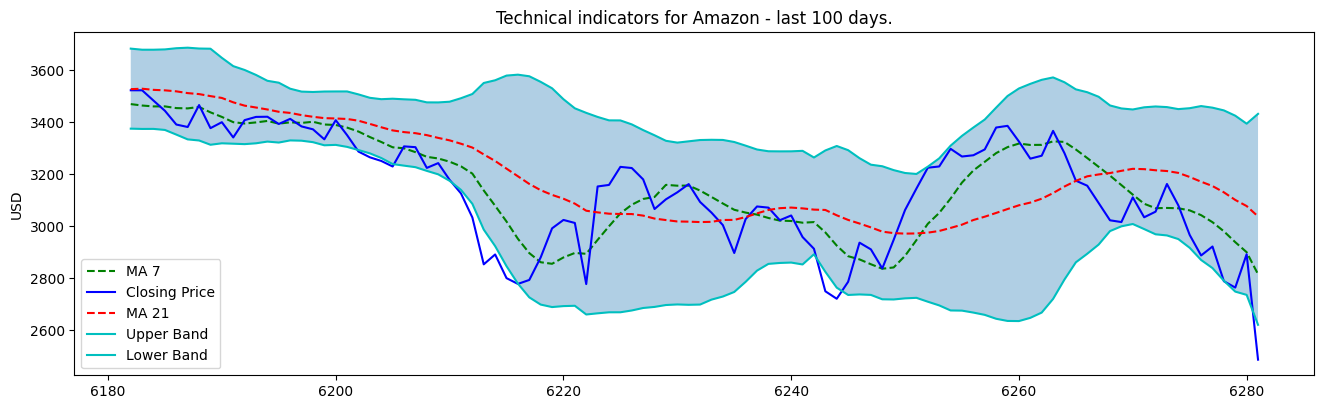

In [15]:
plot_technical_indicators(dataset_TI_df, 100)

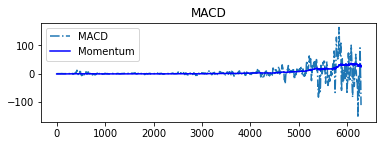

In [16]:
 # Plot second subplot
plt.subplot(2, 1, 2)
plt.title('MACD')
plt.plot(dataset_TI_df['MACD'],label='MACD', linestyle='-.')
# plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
# plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
plt.plot(dataset_TI_df['momentum'],label='Momentum', color='b',linestyle='-')
plt.legend()
plt.show()

**PLOT UNDERSTANDING:** 

THE FIRST PLOT IS SELF EXPLANATORY

THE SECOND PLOT IS SHOWING THE THRESHOLD BETWEEN MACD AND MOMENTUM. AS YOU CAN SEE MOMENTUM IS GIVING AN AVERAGE VALUE OF THE MACD IN BETEEEN THE PEAK VALUES AND THE HIGHEST OR LOWEST VALUES. MACD DEPENDS ON THE MOVING AVERAGE FEATURES AS CALCULATED ABOVE



>  
# **ANALYSIS OF TIME SERIES USING FOURIER TRANSFORM**




In [17]:
data_FT = hist_data[['Date', 'Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


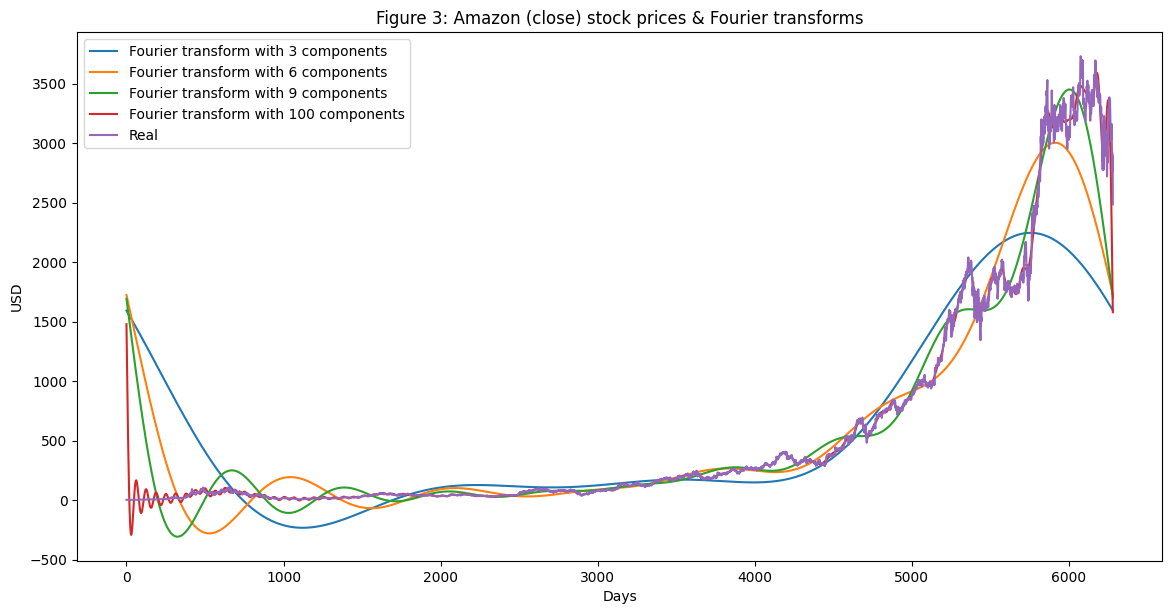

In [18]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Amazon (close) stock prices & Fourier transforms')
plt.legend()
plt.show()


**Fourier Transform uses many spectral components to try and train data. From time domain its converted to frequency domain and then calculated. After that it's reconverted into time domain where it's plotted.**
**Fourier Transform as indicator helps to extract predominate cycle from a series of data**





In [19]:

def get_fourier(dataset):
    data_FT = dataset[['Date', 'Close']]
    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    close_fft = np.fft.ifft(close_fft)
    close_fft
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_list_m10= np.copy(fft_list); fft_list_m10[100:-100]=0
    dataset['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))
    #dataset['absolute'] = dataset['Fourier'].apply(lambda x: np.abs(x))
    return dataset

In [20]:
dataset_TI_df = get_fourier(hist_data)

In [21]:
dataset_TI_df.head(30)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,72156000,0,0.0,NaN,NaN,1.958333,1.958333,0.000000,NaN,NaN,NaN,1.958333,-0.980417,1.958333
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,14700000,0,0.0,NaN,NaN,1.839343,1.834201,-0.005142,NaN,NaN,NaN,1.786458,-0.982708,1.729167
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,6106800,0,0.0,NaN,NaN,1.792272,1.785075,-0.007197,NaN,NaN,NaN,1.732372,-0.982917,1.708333
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,5467200,0,0.0,NaN,NaN,1.748422,1.737834,-0.010589,NaN,NaN,NaN,1.666927,-0.983646,1.635417
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,18853200,0,0.0,NaN,NaN,1.673903,1.653404,-0.020499,NaN,NaN,NaN,1.506370,-0.985729,1.427083
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,11776800,0,0.0,NaN,NaN,1.618207,1.590801,-0.027407,NaN,NaN,NaN,1.432578,-0.986042,1.395833
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,15937200,0,0.0,1.622024,NaN,1.597185,1.570539,-0.026646,NaN,NaN,NaN,1.477546,-0.985000,1.500000
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,8697600,0,0.0,1.568452,NaN,1.594953,1.573209,-0.021744,NaN,NaN,NaN,1.548082,-0.984167,1.583333
8,1997-05-28,1.625000,1.635417,1.531250,1.531250,4574400,0,0.0,1.540178,NaN,1.585511,1.564908,-0.020603,NaN,NaN,NaN,1.536860,-0.984688,1.531250
9,1997-05-29,1.541667,1.541667,1.479167,1.505208,3472800,0,0.0,1.511161,NaN,1.574430,1.553595,-0.020835,NaN,NaN,NaN,1.515758,-0.984948,1.505208


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


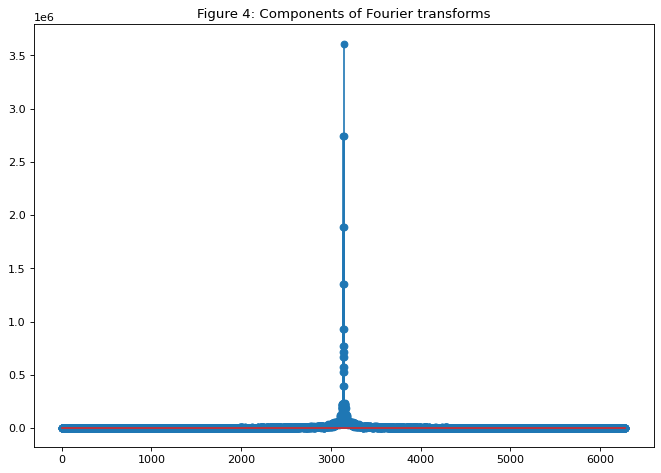

In [22]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

**Component analysis of Fourier Transform**
**Once the spectral part of Fourier transform is removed the magnitude part is quite close to the test series values!** 
**Fourier transform is working!**

# **ARIMA**

 **ARIMA as a feature:**
   
 **Autoregressive Integrated Moving Average (ARIMA) — This was one of the most popular techniques for predicting future values of time series data (in the pre-neural networks ages). Let’s add it and see if it comes off as an important predictive feature.**
   
  **ARIMA is a technique for predicting time series data. We will show how to use it, and all though ARIMA will not serve as our final prediction, we will use it as a technique to denoise the stock a little and to (possibly) extract some new patters or features.**
  
  **ARIMA is an acronym. This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:**









In [23]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6281
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -28379.150
Method:                       css-mle   S.D. of innovations             22.183
Date:                Mon, 02 May 2022   AIC                          56772.300
Time:                        13:29:40   BIC                          56819.517
Sample:                             1   HQIC                         56788.660
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3997      0.257      1.554      0.120      -0.104       0.904
ar.L1.D.Close    -0.0406      0.013     -3.129      0.002      -0.066      -0.015
ar.L2.D.Close    -0.0088      0.013     

 **SUMMARY OF THE ARIMA MODEL**
 
A good starting point for the AR parameter of the model may be 5.

From the summary of the ARIMA we can see that most P-values are greater than 0.05 other than the last two.The model should be great!

The difference between AIC and BIC is low so this indicates this is a good model

Running the example, we can see that there is a positive correlation with the first 0-to-500 lags that is perhaps significant for the first 250 lags in the autocorrelation below



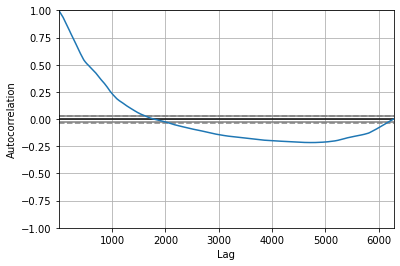

<Figure size 800x560 with 0 Axes>

In [24]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [25]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

dataset_TI_df['ARIMA'] = pd.DataFrame(predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [26]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 1458.413


MSE issquare root of square of average of difference between actual and predicted prices. In this case they MSE is quite big.(MSE ideally for this data should be between 30 and 100). However I will plot the model and check

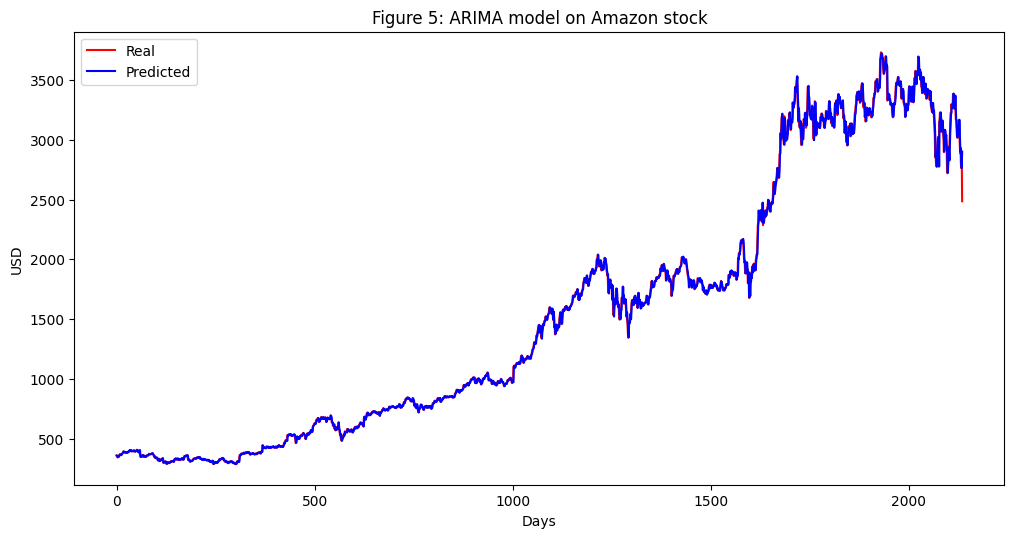

In [27]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='red', label='Real')
plt.plot(predictions, color='blue', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Amazon stock')
plt.legend()
plt.show()

**As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM because, as we mentioned before, we want to capture as many features and patterns about Amazon as possible.**

In [29]:
hist_data.head(8)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,72156000,0,0.0,NaN,NaN,1.958333,1.958333,0.000000,NaN,NaN,NaN,1.958333,-0.980417,1.958333,359.141965
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,14700000,0,0.0,NaN,NaN,1.839343,1.834201,-0.005142,NaN,NaN,NaN,1.786458,-0.982708,1.729167,358.869856
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,6106800,0,0.0,NaN,NaN,1.792272,1.785075,-0.007197,NaN,NaN,NaN,1.732372,-0.982917,1.708333,356.390706
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,5467200,0,0.0,NaN,NaN,1.748422,1.737834,-0.010589,NaN,NaN,NaN,1.666927,-0.983646,1.635417,344.098722
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,18853200,0,0.0,NaN,NaN,1.673903,1.653404,-0.020499,NaN,NaN,NaN,1.506370,-0.985729,1.427083,350.867377
5,1997-05-22,1.437500,1.447917,1.312500,1.395833,11776800,0,0.0,NaN,NaN,1.618207,1.590801,-0.027407,NaN,NaN,NaN,1.432578,-0.986042,1.395833,353.858650
6,1997-05-23,1.406250,1.520833,1.333333,1.500000,15937200,0,0.0,1.622024,NaN,1.597185,1.570539,-0.026646,NaN,NaN,NaN,1.477546,-0.985000,1.500000,349.871711
7,1997-05-27,1.510417,1.645833,1.458333,1.583333,8697600,0,0.0,1.568452,NaN,1.594953,1.573209,-0.021744,NaN,NaN,NaN,1.548082,-0.984167,1.583333,356.503773


In [30]:
print('Total dataset has {} samples, and {} features.'.format(hist_data.shape[0], \
                                                              hist_data.shape[1]))

Total dataset has 6282 samples, and 20 features.


# **FINDING IMPORTANT FEATURES USING XGBOOST :**

In [31]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:,1:19]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [32]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)


In [33]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [34]:
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

[13:43:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
eval_result = regressor.evals_result()

In [36]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

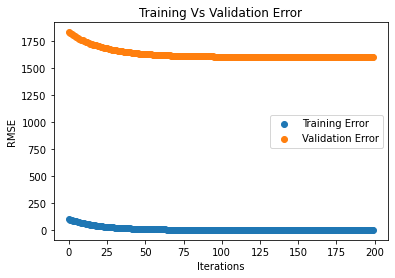

In [37]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

**THE DIFFERENCE BETWEEN VALIDATION AND TRAINING ERROR SHOWS A UNDERFIT MODEL. EXPECTED AS SAID BEFORE BECAUSE OF THE WAY TRAINING AND TESTING DATA IS SPLIT JUST WHEN AMAZON BOOMS!**

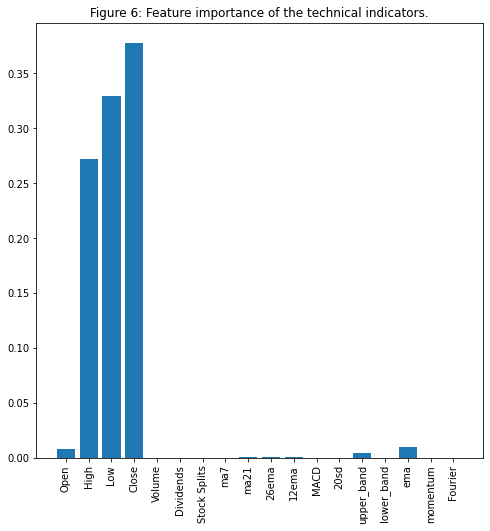

In [38]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

Next steps:
We know which features are important. I suspect Fourier and ARIMA might be equally important but because of their
spectral component Fourier and because ARIMA doesn't produce any other features I won't be consideringthem.

# **LSTM**

**LSTM is great at predicting stock market data. We are going to try to predict the closing prices using 1 feature Open(It has highest correlation to closing price) initially and then using multiple features(use some sort of one hot encoding) and then try to get a output.**

**An LSTM Network has its origin in a RNN. But it can solve the memory loss by changing the neuron architecture.**



In [39]:
#1. take dataframe and drop na
dataset_lstm_df = dataset_TI_df.drop(columns='Date')
dataset_lstm_df.head(7)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA
0,2.437500,2.500000,1.927083,1.958333,72156000,0,0.0,NaN,NaN,1.958333,1.958333,0.000000,NaN,NaN,NaN,1.958333,-0.980417,1.958333,359.141965
1,1.968750,1.979167,1.708333,1.729167,14700000,0,0.0,NaN,NaN,1.839343,1.834201,-0.005142,NaN,NaN,NaN,1.786458,-0.982708,1.729167,358.869856
2,1.760417,1.770833,1.625000,1.708333,6106800,0,0.0,NaN,NaN,1.792272,1.785075,-0.007197,NaN,NaN,NaN,1.732372,-0.982917,1.708333,356.390706
3,1.729167,1.750000,1.635417,1.635417,5467200,0,0.0,NaN,NaN,1.748422,1.737834,-0.010589,NaN,NaN,NaN,1.666927,-0.983646,1.635417,344.098722
4,1.635417,1.645833,1.375000,1.427083,18853200,0,0.0,NaN,NaN,1.673903,1.653404,-0.020499,NaN,NaN,NaN,1.506370,-0.985729,1.427083,350.867377
5,1.437500,1.447917,1.312500,1.395833,11776800,0,0.0,NaN,NaN,1.618207,1.590801,-0.027407,NaN,NaN,NaN,1.432578,-0.986042,1.395833,353.858650
6,1.406250,1.520833,1.333333,1.500000,15937200,0,0.0,1.622024,NaN,1.597185,1.570539,-0.026646,NaN,NaN,NaN,1.477546,-0.985000,1.500000,349.871711


In [40]:
print('Total dataset has {} samples, and {} features.'.format(dataset_lstm_df.shape[0], \
                                                              dataset_lstm_df.shape[1]))

Total dataset has 6282 samples, and 19 features.


In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [42]:
#creating test, train and validate trains
train, validate, test = np.split(dataset_lstm_df.sample(frac=1), [int(.6*len(dataset_lstm_df)), int(.8*len(dataset_lstm_df))])

**Split dataset into train,test and validate sets**

In [43]:
open_training = train.iloc[:, 1:2].values

In [44]:
#normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
open_training = scaler.fit_transform(open_training)
#convert to right shape
features_set_1 = []
labels_1 = []
for i in range(60,450): 
    features_set_1.append(open_training[i-60:i, 0])
    labels_1.append(open_training[i, 0])


**Convert feature set and label set into arrays and shape feature set into a 3D input that LSTM network demands**

In [45]:
features_set_1, labels_1 = np.array(features_set_1), np.array(labels_1)
features_set_1 = np.reshape(features_set_1, (features_set_1.shape[0], features_set_1.shape[1], 1))

In [46]:
#training it
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set_1.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(features_set_1, labels_1, epochs = 100, batch_size = 32,validation_data = (features_set_1, labels_1))


Epoch 1/100
13/13 [==============================] - 10s 181ms/step - loss: 0.0525 - mean_absolute_error: 0.1555 - val_loss: 0.0533 - val_mean_absolute_error: 0.1919
Epoch 2/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0528 - mean_absolute_error: 0.1592 - val_loss: 0.0506 - val_mean_absolute_error: 0.1769
Epoch 3/100
13/13 [==============================] - 1s 45ms/step - loss: 0.0516 - mean_absolute_error: 0.1751 - val_loss: 0.0535 - val_mean_absolute_error: 0.1382
Epoch 4/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0524 - mean_absolute_error: 0.1526 - val_loss: 0.0511 - val_mean_absolute_error: 0.1815
Epoch 5/100
13/13 [==============================] - 1s 51ms/step - loss: 0.0505 - mean_absolute_error: 0.1685 - val_loss: 0.0501 - val_mean_absolute_error: 0.1542
Epoch 6/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0500 - mean_absolute_error: 0.1592 - val_loss: 0.0496 - val_mean_absolute_error: 0.1655
Epoch 7/100
13

**MAE: This means the average difference between input and ouput for all  datapoints is 0.167. 
However the value is for the days here so the MAE here is pretty bad.


**Data is trained for 100 epochs optimizer is adam and loss is mse. This seems to be an average model because mean absolute error is 0.18 and val mean absolute eroor is 0.17 so it indicates overfitting. Since this is a regression problem accuracy is not a good metric. MAE was chosen since the difference between training and testing should be less so we don't need to take the square root of the value.** 

**We will focus on hyperparameters if this model is good at prediction**

In [47]:
#TESTING THE MODEL
open_testing_processed = test.iloc[:, 1:2].values

**Test the model on test data**

In [48]:
#convert test data to right format
open_total = pd.concat((train['Open'], test['Open']), axis=0)

**Start predictions:
Reshape, scale and then oredict the model**

In [49]:
test_inputs = open_total[len(open_total) - len(test) - 60:].values

In [50]:
#scaling data
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [51]:
test_features = []
for i in range(60, 151):
    test_features.append(test_inputs[i-60:i, 0])

In [52]:
test_features = np.array(test_features)
test_features.shape
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

In [53]:
#make predictions
predictions = model.predict(test_features)

In [54]:
predictions = scaler.inverse_transform(predictions)

**Plot the prediction model for the number of test days and train days**

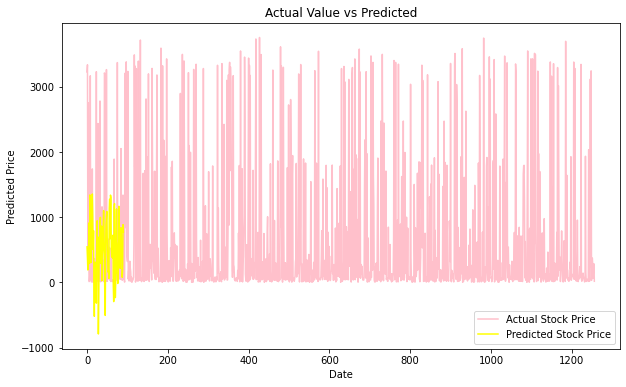

In [55]:
plt.figure(figsize=(10,6))
plt.plot(open_testing_processed, color='pink', label='Actual Stock Price')
plt.plot(predictions , color='yellow', label='Predicted Stock Price')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


**This wasn't a great result with one feature so let's try using more features and then train them on LSTM model**

**USING 5FEATURES :**


**USING THE BEST 5 FEATURES FROM THE RESULT OF THE XGBOOST. ITS QUITE OBVIOUS THAT A SINGLE FEATURE WILL NOT WORK SO WE USE THE 6 FEATURES THAT
COULD GENERATE THE BEST OUTCOME FROM XGBOOST**

In [58]:
dataset = hist_data[['Open', 'Close','High','Low']]

In [59]:
dataset.head()

,Open,Close,High,Low
0,2.437500,1.958333,2.500000,1.927083
1,1.968750,1.729167,1.979167,1.708333
2,1.760417,1.708333,1.770833,1.625000
3,1.729167,1.635417,1.750000,1.635417
4,1.635417,1.427083,1.645833,1.375000


In [60]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [61]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


In [62]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [63]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])

In [64]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [65]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

In [1]:
# PLOTTING All INDICATORS IN PLOT
imp
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'pink', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()


NameError: ignored

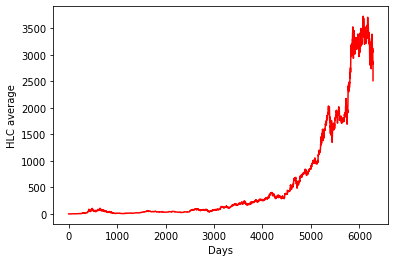

In [67]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()


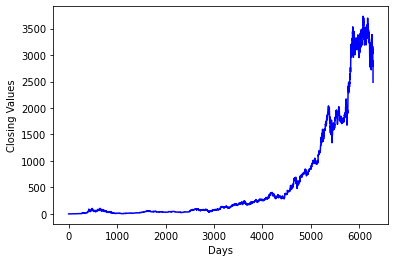

In [68]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [69]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [70]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [71]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [72]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1


In [73]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [75]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
4709/4709 - 28s - loss: 0.0407 - mae: 0.1616 - 28s/epoch - 6ms/step
Epoch 2/10
4709/4709 - 19s - loss: 0.0329 - mae: 0.1464 - 19s/epoch - 4ms/step
Epoch 3/10
4709/4709 - 19s - loss: 0.0263 - mae: 0.1319 - 19s/epoch - 4ms/step
Epoch 4/10
4709/4709 - 19s - loss: 0.0205 - mae: 0.1166 - 19s/epoch - 4ms/step
Epoch 5/10
4709/4709 - 19s - loss: 0.0156 - mae: 0.1018 - 19s/epoch - 4ms/step
Epoch 6/10
4709/4709 - 18s - loss: 0.0115 - mae: 0.0869 - 18s/epoch - 4ms/step
Epoch 7/10
4709/4709 - 19s - loss: 0.0082 - mae: 0.0737 - 19s/epoch - 4ms/step
Epoch 8/10
4709/4709 - 19s - loss: 0.0057 - mae: 0.0610 - 19s/epoch - 4ms/step
Epoch 9/10
4709/4709 - 19s - loss: 0.0038 - mae: 0.0497 - 19s/epoch - 4ms/step
Epoch 10/10
4709/4709 - 19s - loss: 0.0025 - mae: 0.0399 - 19s/epoch - 4ms/step


In [76]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

99/99 [==============================] - 1s 4ms/step - loss: 0.0013 - mae: 0.0356
Mean Absolute Error for Y: [0.0012720458908006549, 0.035644274204969406]


**The mean absolute error is lower than the past model with one feature. The errror is almost 0.0026. So the training model should be pretty close to testing model.**

In [77]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [78]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [79]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))

Train : 166.88


In [80]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 132.95


In [81]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [82]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

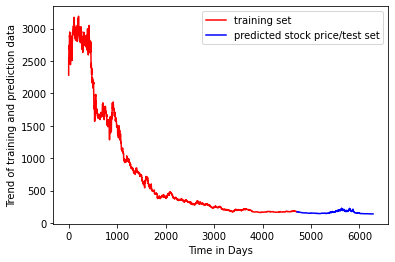

In [83]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()


**We trained our data for the first 1700 or so days and then tested for the rest. The prediction plot has kept up with the pattern how ever not to my satisfaction.**

In [84]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)


Last Day Value: 139.40843200683594
Next Day Value: 119.3088150024414


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
